<a href="https://colab.research.google.com/github/j-c-stuifbergen/machine-learning-for-physicists/blob/master/06_tutorial_LSTM_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Recurrent Neural Networks to predict physical time evolution

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 6, Tutorial (this is discussed in session 6)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- train a recurrent network (LSTM) to correctly predict the coordinate of a particle that can only be predicted based on previous observations

The physical example is a 'heavy' particle immersed in a bath of 'light' particles. We are only allowed to observe the motion of the heavy particle, but we want to predict the coordinate of one of the **other** particles (which are initialized randomly in each run). This can only be done by exploiting memory, using the past observations of the heavy particle's motion, to infer what the others are doing.

![image.png](attachment:9eb12442-a56a-49fa-8824-784d77d6e345.png)

### Imports: numpy and matplotlib and keras

In [ ]:
# keras: Sequential is the neural-network class, Dense is
# the standard network layer
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

### Runge-Kutta solver for a set of differential equations

In contrast to many solvers you find in libraries, this one can deal with a solution X(t) that is an array of an arbitrary number of dimensions. This will be convenient for batch processing etc.

In [ ]:
def runge_kutta_step(X,rhs,dt):
    """
    One step of the standard Runge-Kutta fourth order. I implemented this here
    to avoid dependency on any external package (you can find nice
    implementations in scipy, for example)
    """
    k1=rhs(X)
    k2=rhs(X+0.5*dt*k1)
    k3=rhs(X+0.5*dt*k2)
    k4=rhs(X+dt*k3)
    return( (dt/6.)*(k1+2*k2+2*k3+k4) )

def solve(X0,rhs,T,nsteps):
    """
    Solve the differential equation dX/dt=rhs(X), for 'nsteps' time steps up to time T,
    with initial value X(t=0)=X0.
    
    Here X0 can have ANY shape as an array, and rhs(X) must return the same shape.
    
    This is convenient in case you want to, say, do many trajectories in parallel,
    or reserve one index for the particle number, etc. You do not need to assume
    X to be a 1d array, as you would have to do for some other Runge-Kutta implementations.
    It is also nice to split the positions and velocities, e.g. X[0,:] for the positions
    of all particles, and X[1,:] for the velocities.
    
    Returns: Xs,ts
    
    where the shape of the solution Xs is the same as that of X, except we add another dimension
    at the end, of size 'nsteps'. 'ts' just is a 1d array denoting the time steps for
    the solution.
    
    Plotting the solution may work like this, if X was a 1d array:
    
    plt.plot(ts,Xs[5]) # Note that Xs[5] is the same as Xs[5,:]
    
    ...or like this, if e.g. X[1,:] were all the velocities of all particles:
    
    plt.plot(ts,Xs[1,3]) # plotting velocity of particle number 3: Xs[1,3] is the same as Xs[1,3,:]
    
    (code by Florian Marquardt)
    """
    dt=T/nsteps
    X=np.array(X0,dtype='float')
    Xs=np.zeros(np.shape(X0)+(nsteps,)) # to store all the results: add 'nsteps' dimension
    for j in range(nsteps):
        X+=runge_kutta_step(X,rhs,dt)
        Xs[...,j]=X # store result (... means: we don't care how many dimensions there are!)
    ts=dt*(np.array(range(nsteps))+1) # all time points
    return(Xs,ts)

def solve_constrained(X0,rhs,T,nsteps,Xs_given,mask):
    """
    Solve the differential equation dX/dt=rhs(X), for 'nsteps' time steps up to time T,
    with initial value X(t=0)=X0. See details inside the help for 'solve'.
    
    However, you provide a mask, which is an array of the same shape as X0. Wherever
    this is 1.0, the solution will be calculated in the normal way. Wherever this is 0.0,
    the differential equation will not be followed - instead, the values inside Xs_given
    will be used (which is an array of the same shape as X0, plus a last dimension of
    size nsteps).
    
    This allows you to explore how the solution would look like if some particles
    were following some particular given trajectory (so: what is their effect on the
    other particles, which are still free to move?)
    
    Returns: Xs,ts
    """
    dt=T/nsteps
    X=np.array(X0,dtype='float')
    Xs=np.zeros(np.shape(X0)+(nsteps,)) # to store all the results: add 'nsteps' dimension
    for j in range(nsteps):
        X=mask*X+(1-mask)*Xs_given[...,j] # CHANGED vs solve
        X+=mask*runge_kutta_step(X,rhs,dt) # CHANGED vs solve
        Xs[...,j]=X # store result (... means: we don't care how many dimensions there are!)
    ts=dt*(np.array(range(nsteps))+1) # all time points
    return(Xs,ts)

### Simple harmonic oscillator (to show how this works)

In [ ]:
def one_harmonic_oscillator_rhs(X):
    # assume X[0] is the coordinate x, X[1] is the velocity v
    return( np.array( [
        X[1],     # dx/dt = v
        -X[0]     # dv/dt = -x
    ] ))

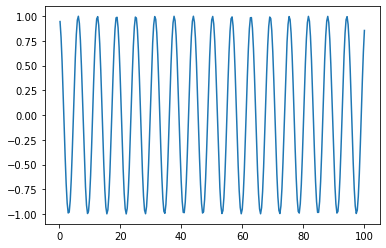

In [ ]:
Xs,ts=solve(X0=[1,0],rhs=one_harmonic_oscillator_rhs,T=100.0,nsteps=300)
plt.plot(ts,Xs[0])
plt.show()

### Now: multiple coupled oscillators

Here all the oscillators j=1,2,3,... are coupled to the one special oscillator j=0: 

$$ m_0 {d^2x_0 \over dt^2} = -k_0 x_0 + \sum_{j>0} D_j (x_j-x_0)$$

and (for j>0):

$$ m_j {d^2x_j \over dt^2} = -k_j x_j + D_j (x_0-x_j)$$

In [ ]:
def multiple_coupled_oscillators_rhs(X):
    # X[0,:] are all the coordinates for all particles (second index)
    # X[1,:] are all the velocities
    global multiple_coupled_oscillators_k # the spring constants for all the oscillators (array)
    global multiple_coupled_oscillators_D # coupling spring constant (array)
    global multiple_coupled_oscillators_m # the masses (array)
    
    # all the terms for the oscillators j=1,2,3,... being affected by j=0:
    coupling_acceleration=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m)*(X[0,0]-X[0,:])
    # and now the force acting on j=0, from all the others:
    coupling_acceleration[0]=np.sum(multiple_coupled_oscillators_D*X[0,:]-X[0,0]
                                    )/multiple_coupled_oscillators_m[0]
    #                                axis=0)/multiple_coupled_oscillators_m[0]

    """ redundant formulation
    # all the terms for the oscillators j=1,2,3,... being affected by j=0:
    D_over_m=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m)
    coupling_acceleration=D_over_m*(X[0,0]-X[0,:])
    # and now the force acting on j=0, from all the others:
    D_over_m0=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m[0])
    coupling_acceleration[0]=np.sum(D_over_m0*(X[0,:]-X[0,0]),axis=0)
    """    
    return(np.array(
        [
            X[1,:], # dx/dt=v
            -(multiple_coupled_oscillators_k/multiple_coupled_oscillators_m)*X[0,:]+\
            coupling_acceleration # dv/dt=force/mass
        ]
    ))

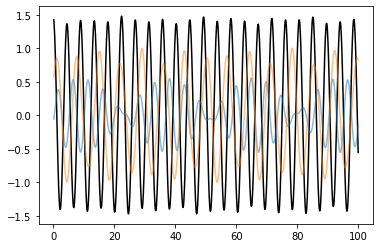

In [ ]:
multiple_coupled_oscillators_k=np.array([1.0,1.3,0.7]) # the spring constants
multiple_coupled_oscillators_D=0.1 # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.array([2.0,1.0,1.0]) # the masses

X0=np.random.randn(2,3) # first index: x vs. v / second index: particles
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_rhs,T=100.0,nsteps=1000)
for n in range(3):
    if n==0:
        color="black" # our 'heavy' particle!
        alpha=1
    else:
        color=None
        alpha=0.5
    plt.plot(ts,Xs[0,n],color=color,alpha=alpha)
plt.show()

### Multiple coupled oscillators, batch processing (many trajectories in parallel!)

We simply add a third index to X, which is now an array of shape [2,particle_number,batchsize]. The usual array indexing gymnastics are required to make it work.

In [ ]:
def multiple_coupled_oscillators_parallel_rhs(X):
    # X[0,:,:] are all the coordinates for all particles (second index) and all trajectories (third index)
    # X[1,:,:] are all the velocities
    global multiple_coupled_oscillators_k # the spring constants for all the oscillators (array)
    global multiple_coupled_oscillators_D # coupling spring constant (array)
    global multiple_coupled_oscillators_m # the masses (array)
    
    # all the terms for the oscillators j=1,2,3,... being affected by j=0:
    D_over_m=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m)[:,None]
    coupling_acceleration=D_over_m*(X[0,0,:][None,:]-X[0,:,:])
    # and now the force acting on j=0, from all the others:
    D_over_m0=(multiple_coupled_oscillators_D/multiple_coupled_oscillators_m[0])[:,None]
    coupling_acceleration[0]=np.sum(D_over_m0*(X[0,:,:]-X[0,0,:][None,:]),axis=0)
    
    return(np.array(
        [
            X[1,:,:], # dx/dt=v
            -(multiple_coupled_oscillators_k/multiple_coupled_oscillators_m)[:,None]*X[0,:,:]+\
            coupling_acceleration # dv/dt=force/mass
        ]
    ))



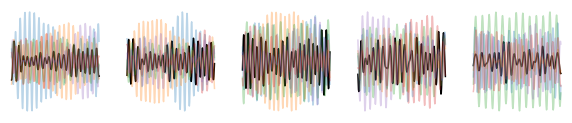

In [ ]:
number_particles=6
multiple_coupled_oscillators_k=np.abs( 0.2*np.random.randn(number_particles)+1.0 ) # the spring constants
multiple_coupled_oscillators_D=np.full(number_particles,0.2) # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.abs( 0.2*np.random.randn(number_particles)+1.0 ) # the masses
multiple_coupled_oscillators_m[0]=3.0 # heavy particle
multiple_coupled_oscillators_k[0]=3.0 # hard spring: make it still resonant with the rest!

batchsize=5
X0=np.random.randn(2,number_particles,batchsize) # first index: x vs. v / second index: particles / third: batch
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=100.0,nsteps=300)

fig,ax=plt.subplots(ncols=batchsize,nrows=1,figsize=(batchsize*2,2))
for j in range(batchsize):
    for n in range(number_particles):
        if n==0:
            color="black" # our 'heavy' particle!
            alpha=1
        else:
            color=None
            alpha=0.3
        ax[j].plot(ts,Xs[0,n,j],color=color,alpha=alpha)
        ax[j].axis('off')
plt.show()

Obviously, the heavy particle is strongly influenced by the other particles. 

We will now try to predict the motion of particle 1 based purely on the observations of the heavy particle (number 0)! By observing the full trajectory of the heavy particle, one has to try to infer indirectly what the other particles are up to! This only works with some memory (the current position of particle 0 is not enough).

### Setting up an LSTM network and training it!

In [ ]:
def makeLSTM(units = 20):
  Network=Sequential()

  Network.add(LSTM(units,input_shape=(None,1),
  #             activation="linear",
  #             recurrent_activation="linear",
              return_sequences=True)) # LSTM layer with 10 neurons
  Network.add(Dense(1,activation="linear"))

  Network.compile(loss='mean_squared_error',
                optimizer='adam')
  return Network
 


In [ ]:
# assuming we can take the solution Xs from above, 
# let's see what the network makes of this!
Net = makeLSTM()

X1=Net.predict_on_batch(Xs[0,0,:,:][:,:,None]) # needs input of shape [batchsize,timesteps,1]

In [ ]:
np.shape(X1)

(5, 300, 1)

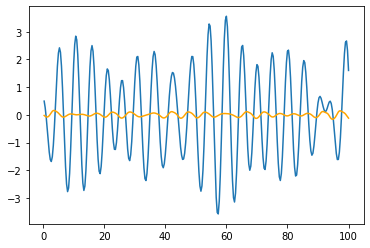

In [ ]:
sample=3
plt.plot(ts,Xs[0,1,sample,:])
plt.plot(ts,X1[sample,:,0],color="orange")
plt.show()

#### Now: Two particles, coupled to each other!

In [ ]:
number_particles=2
multiple_coupled_oscillators_k=np.array([0.1,0.0]) # the spring constants
multiple_coupled_oscillators_D=np.array([0.0,0.2]) # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.array([2.0,1.0]) # the masses

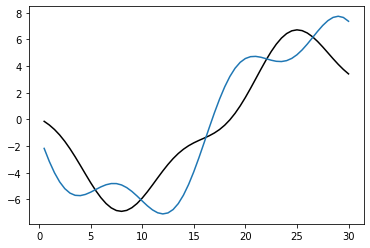

In [ ]:
# create one test trajectory
X0=np.random.randn(2,number_particles,1)
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
plt.plot(ts,Xs[0,0,0],color="black")
plt.plot(ts,Xs[0,1,0])
plt.show()

#### The actual training!

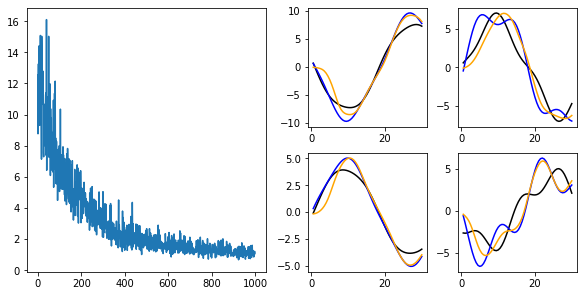

In [ ]:
training_steps=1000 # number of training steps
batchsize=50 # batch size
costs=np.zeros(training_steps)

nsteps=60 # number of time steps
T=30.0 # total time interval

skip_steps=10 # plot every ... steps

# create one batch of test trajectories, to compare against!
X0=np.random.randn(2,number_particles,4)
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=30.0,nsteps=60)
test_input=Xs[0,0,:,:][:,:,None] # will need shape [batchsize,timesteps,1]
test_correct_output=Xs[0,1,:,:][:,:,None] # shape [batchsize,timesteps,1]

for j in range(training_steps):
    X0=np.random.randn(2,number_particles,batchsize) # random initial conditions
    Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=T,nsteps=nsteps) # get solutions
    costs[j]=Net.train_on_batch(Xs[0,0,:,:][:,:,None],Xs[0,1,:,:][:,:,None]) # train x_0(t)->x_1(t) mapping
    # needs input and output of shape [batchsize,timesteps,1]
    if j%skip_steps==0 or j==training_steps-1:
        clear_output(wait=True)
        fig=plt.figure(constrained_layout=True,figsize=(8,4))
        gs=fig.add_gridspec(ncols=4,nrows=2)
        cost_plot=fig.add_subplot(gs[0:2,0:2])
        cost_plot.plot(costs)
        test_output=Net.predict_on_batch(test_input) # get some test predictions
        for n in range(4):
            theplot=fig.add_subplot(gs[n%2,2+int(n/2)])
            theplot.plot(ts,test_input[n,:,0],color="black") # particle 0
            theplot.plot(ts,test_correct_output[n,:,0],color="blue") # particle 1
            theplot.plot(ts,test_output[n,:,0],color="orange") # NN-predicted particle 1
        plt.show()


### Try to figure out what this network is doing!

Idea: give some hand-crafted input and see what happens to it!

#### Constant input

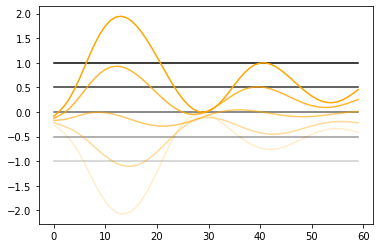

In [ ]:
# use the times ts from above

for idx,offset in enumerate([-1.0,-0.5,0.0,+0.5,+1.0]):
    x_0=0*ts+offset
    test_input=np.zeros([1,nsteps,1])
    test_input[0,:,0]=x_0

    test_output=Net.predict_on_batch(test_input)
    plt.plot(x_0,color="black",alpha=1.0*(idx+1)/5.0)
    plt.plot(test_output[0,:,0],color="orange",alpha=1.0*(idx+1)/5.0)

plt.show()

#### Step input

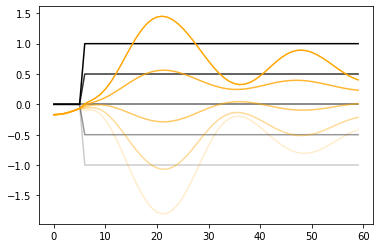

In [ ]:
# use the times ts from above

t_0=0.1*T

for idx,offset in enumerate([-1.0,-0.5,0.0,+0.5,+1.0]):
    x_0=0*ts+offset*(ts>t_0)
    test_input=np.zeros([1,nsteps,1])
    test_input[0,:,0]=x_0

    test_output=Net.predict_on_batch(test_input)
    plt.plot(x_0,color="black",alpha=1.0*(idx+1)/5.0)
    plt.plot(test_output[0,:,0],color="orange",alpha=1.0*(idx+1)/5.0)

plt.show()

#### Test linearity: do the responses scale with the input amplitude?

We will plot the response (minus the response for zero amplitude), always divided by the input amplitude. Ideally, if the network response is linear, all these curves will lie on top of each other.

Of course, the only reason to expect the network response to be linear is that this is a linear system of equations of motion, so presumably the optimal strategy for predicting the coordinate of particle 1 is also linear...

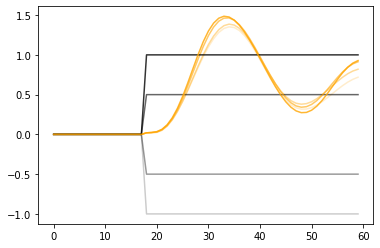

In [ ]:
t_0=0.3*T

offsets=np.array([-1.0,-0.5,+0.5,+1.0])

x_0=0*ts
test_input=np.zeros([1,nsteps,1])
test_input[0,:,0]=x_0
prediction_for_zero=Net.predict_on_batch(test_input)  

for idx,offset in enumerate(offsets):
    x_0=0*ts+offset*(ts>t_0)
    test_input=np.zeros([1,nsteps,1])
    test_input[0,:,0]=x_0

    test_output=Net.predict_on_batch(test_input)
    rescaled_response=(test_output[0,:,0]-prediction_for_zero[0,:,0])/offset
    plt.plot(x_0,color="black",alpha=1.0*(idx+1)/5.0)
    plt.plot(rescaled_response,color="orange",alpha=1.0*(idx+1)/5.0)

plt.show()

#### A smooth step

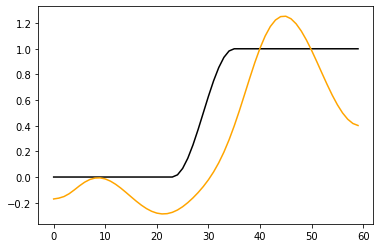

In [ ]:
# a smooth step (constructed using a sin function)
t_0=0.4*T
t_1=0.6*T
x_0=(ts>=t_0)*(ts<=t_1)*(1+np.sin(np.pi*((ts-t_0)/(t_1-t_0)-0.5)))*0.5 + (ts>t_1)*1.0
test_input=np.zeros([1,nsteps,1])
test_input[0,:,0]=x_0

test_output=Net.predict_on_batch(test_input)
plt.plot(x_0,color="black")
plt.plot(test_output[0,:,0],color="orange")
plt.show()

#### Testing linearity for the smooth step

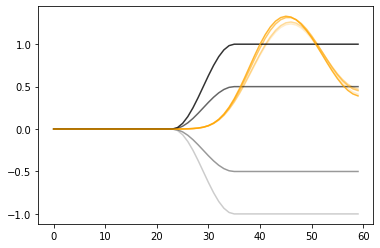

In [ ]:
t_0=0.4*T
t_1=0.6*T

offsets=np.array([-1.0,-0.5,+0.5,+1.0])

x_0=0*ts
test_input=np.zeros([1,nsteps,1])
test_input[0,:,0]=x_0
prediction_for_zero=Net.predict_on_batch(test_input)  

for idx,offset in enumerate(offsets):
    x_0=(ts>=t_0)*(ts<=t_1)*(1+np.sin(np.pi*((ts-t_0)/(t_1-t_0)-0.5)))*0.5*offset + (ts>t_1)*offset
    test_input=np.zeros([1,nsteps,1])
    test_input[0,:,0]=x_0

    test_output=Net.predict_on_batch(test_input)
    rescaled_response=(test_output[0,:,0]-prediction_for_zero[0,:,0])/offset
    plt.plot(x_0,color="black",alpha=1.0*(idx+1)/5.0)
    plt.plot(rescaled_response,color="orange",alpha=1.0*(idx+1)/5.0)

plt.show()

#### Test superposition principle (i.e. linearity for adding two inputs: do the responses add?)

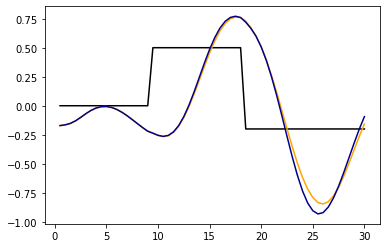

In [ ]:
# Will test response for two steps individually, and then for the combination of both!
t_1=0.3*T
t_2=0.6*T

# get the network prediction for individual steps!
prediction_for={} # store the results in a dictionary
for t_step in [t_1,t_2]: # steps at two different positions
    x_0=0*ts+1.0*(ts>t_step)
    test_input=np.zeros([1,nsteps,1])
    test_input[0,:,0]=x_0
    prediction_for[t_step]=Net.predict_on_batch(test_input)[0,:,0]

# response for zero input:
x_0=0*ts
test_input=np.zeros([1,nsteps,1])
test_input[0,:,0]=x_0
prediction_for[0]=Net.predict_on_batch(test_input)[0,:,0]

offset_1=0.5
offset_2=-0.7

x_0=0*ts+offset_1*(ts>t_1)+offset_2*(ts>t_2)
test_input=np.zeros([1,nsteps,1])
test_input[0,:,0]=x_0
test_output=Net.predict_on_batch(test_input)

expected_response=prediction_for[0]+offset_1*(prediction_for[t_1]-prediction_for[0])+offset_2*(prediction_for[t_2]-prediction_for[0])

plt.plot(ts,x_0,color="black")
plt.plot(ts,test_output[0,:,0],color="orange")
plt.plot(ts,expected_response,color="darkblue")
plt.show()

#### Full overview of network response: just try all unit step functions!

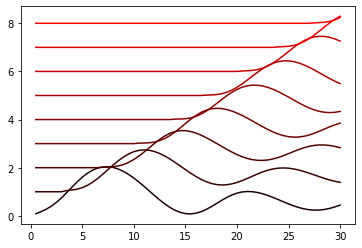

In [ ]:
n_curves=9
t_steps=np.linspace(0.0*T,0.9*T,n_curves)

# response for zero input:
x_0=0*ts
test_input=np.zeros([1,nsteps,1])
test_input[0,:,0]=x_0
prediction_for_0=Net.predict_on_batch(test_input)[0,:,0]

for idx,t_step in enumerate(t_steps):
    x_0=0*ts+(ts>t_step)
    test_input=np.zeros([1,nsteps,1])
    test_input[0,:,0]=x_0

    test_output=Net.predict_on_batch(test_input)
    s=1.0*(idx+1)/n_curves
    plt.plot(ts,test_output[0,:,0]-prediction_for_0 + idx,color=[s,0,0])

plt.show()

#### For comparison: see what happens physically to particle 1 if the heavy particle suddenly jumps to another position

Plot the response of particle 1 (i.e. its evolution with the jump minus that without the jump)

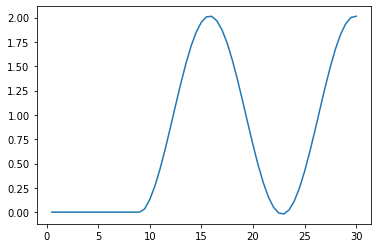

In [ ]:
t_step=0.3*T
dt=T/nsteps

mask=np.full([2,number_particles,1],1.0)
mask[0,0,0]=0.0
mask[1,0,0]=0.0
X0=np.random.randn(2,number_particles,1) # last index is batchsize

Xs={}
for jumpsize in [0.0,1.0]:
    x_0=0*ts+jumpsize*(ts>t_step)
    Xs_given=np.zeros([2,number_particles,1,nsteps])
    Xs_given[0,0,0,:]=x_0
    Xs_given[1,0,0,int(t_step/dt)]=jumpsize/dt # the velocity has a jump
    Xs[jumpsize],ts=solve_constrained(X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=T,nsteps=nsteps,
                 Xs_given=Xs_given,mask=mask)

plt.plot(ts,Xs[1.0][0,1,0,:]-Xs[0.0][0,1,0,:])
plt.show()

Conclusion: the network does something different than merely predicting the response of particle 1 to the observed motion of particle 0!

## Tutorial Exercise

Consider the following situation, defined by the code cell below.

(1) Discuss the physical meaning (look closely at the spring constants!)

(2) Plot an example trajectory

(3) Train and check to see whether the NN gets the answer essentially correct. Why would it be impossible to get this answer purely by looking at the acceleration of the heavy particle?

(4) If you have time (or as a homework), try to understand the NN response!

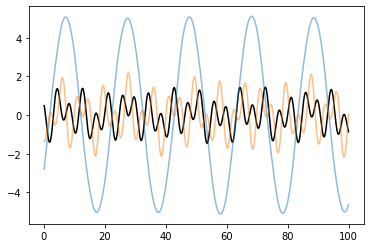

In [ ]:
number_particles=3
multiple_coupled_oscillators_k=np.array([0.1,0.0,0.3]) # the spring constants
multiple_coupled_oscillators_D=np.array([0.0,0.1,1.0]) # the coupling between j=0 and the rest
multiple_coupled_oscillators_m=np.array([2.0,1.0,1.0]) # the masses

X0=np.random.randn(2,3) # first index: x vs. v / second index: particles
Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_rhs,T=100.0,nsteps=1000)
for n in range(3):
    if n==0:
        color="black" # our 'heavy' particle!
        alpha=1
    else:
        color=None
        alpha=0.5
    # if 1==n:
    #    color = "green"
    plt.plot(ts,Xs[0,n],color=color,alpha=alpha)
plt.show()

In [ ]:
def inputTruncatedSeries(   p_in = 1 , # the particle of which the position is given
                  p_out = 1, # the particle of which the position is predicted
                  nParticles = multiple_coupled_oscillators_m.size,
                  nsteps=60,  T=30.0, # total time interval
                  sizeOfBatch =1, noisyTruncation = false):
  X0=np.random.randn(2,nParticles,sizeOfBatch)
  Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=T,nsteps=nsteps)
  input=Xs[0,p_in,:,:][:,:,None].copy() # will need shape [sizeOfBatch,timesteps,1]
  if noisyTruncation:
    # insert random values
    input[:,int(nsteps/2):,:]=np.random.random(sizeOfBatch,nsteps-int(nsteps/2),1)
  else:
    input[:,int(nsteps/2):,:]=0.0

  correct_output=Xs[0,p_out,:,:][:,:,None] # shape [sizeOfBatch,timesteps,1]

  return input, correct_output, Xs[0,:,:,:], ts

def inputSeries(   p_in = 0 , # the particle of which the position is given
                  p_out = 1, # the particle of which the position is predicted
                  nsteps=60,  T=30.0, # total time interval
                  sizeOfBatch =1):

  X0=np.random.randn(2,number_particles,sizeOfBatch)
  Xs,ts=solve(X0=X0,rhs=multiple_coupled_oscillators_parallel_rhs,T=T,nsteps=nsteps)
  input=Xs[0,p_in,:,:][:,:,None] # will need shape [sizeOfBatch,timesteps,1]
  correct_output=Xs[0,p_out,:,:][:,:,None] # shape [sizeOfBatch,timesteps,1]

  return input, correct_output, Xs[0,:,:,:], ts

def plot4figs(input, correct_output, output, graphs, ts):
  fig=plt.figure(constrained_layout=True,figsize=(8,4))
  gs=fig.add_gridspec(ncols=2,nrows=2)
  # cost_plot=fig.add_subplot(gs[0:2,0:2])
  for n in range(4):
      theplot=fig.add_subplot(gs[int(n/2),n%2])
      # plot each particle
      for p in range(multiple_coupled_oscillators_m.size):
        theplot.plot(ts,graphs[p,n,:]) # particle 0
      theplot.plot(ts,input[n,:,0],color="black") # particle 0
      theplot.plot(ts,correct_output[n,:,0],color="blue") # particle 1
      theplot.plot(ts,output[n,:,0],color="red") # NN-predicted particle 1
  plt.show()


In [ ]:
def plotSolutions(theplot, nGraphs, batchId, input, correct_output, nn_output, graphs, ts):
  # plot each particle
  for p in range(nGraphs):
    theplot.plot(ts,graphs[p,batchId,:]) # [:,None]) 
  # compare calculations
  theplot.plot(ts,input[batchId,:,0],color="black") 
  theplot.plot(ts,correct_output[batchId,:,0],color="blue")
  theplot.plot(ts,nn_output[batchId,:,0],color="red") # NN-predicted particle 1

def trainNetwork(makeInputs, # takes as parameter: batchsize
                 Net = makeLSTM(20), training_steps=1000, batchsize=50,
                   skip_steps=10, # plot every ... steps
                  nParticles = 0): # will create rubbish if 0=nParticles 
  costs=np.zeros(training_steps)

  # create one batch of test trajectories, to compare against!

  # We don't need a separate test input.
  # I will use training data, because the influence of 4 training graphs is small
  # test_input, test_correct_output, test_graphs, ts= makeInputs(nB =4)

  for j in range(training_steps):
      input, correct_output, graphs, ts = makeInputs(nB =batchsize)
      costs[j]=Net.train_on_batch(input,correct_output) 
      # needs input and output of shape [batchsize,timesteps,1]
      if j%skip_steps==0 or j==training_steps-1:
          clear_output(wait=True)
          fig=plt.figure(constrained_layout=True,figsize=(8,4))
          gs=fig.add_gridspec(ncols=4,nrows=2)
          cost_plot=fig.add_subplot(gs[0:2,0:2])
          cost_plot.plot(costs)
          output=Net.predict_on_batch(input) # get some test predictions
          for n in range(4):
            theplot=fig.add_subplot(gs[n%2,2+int(n/2)])
            plotSolutions(theplot,nParticles, n, input, correct_output, output, graphs, ts)  
              
          plt.show()
  return Net

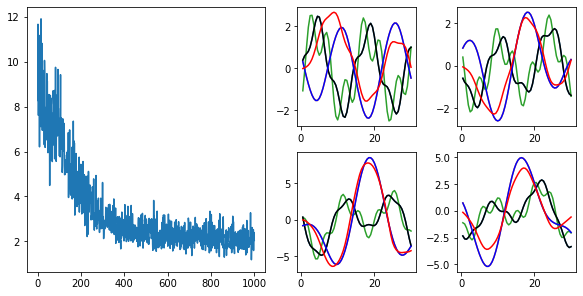

In [ ]:

batchsize=50 # batch size
costs=np.zeros(training_steps)

nsteps=60 # number of time steps
T=30.0 # total time interval

make_inputs = lambda nB:inputSeries(p_in=0,p_out=1, nsteps=nsteps, T=T, sizeOfBatch = nB)

network=trainNetwork(makeInputs = make_inputs, batchsize=batchsize,
                     nParticles = multiple_coupled_oscillators_m.size)

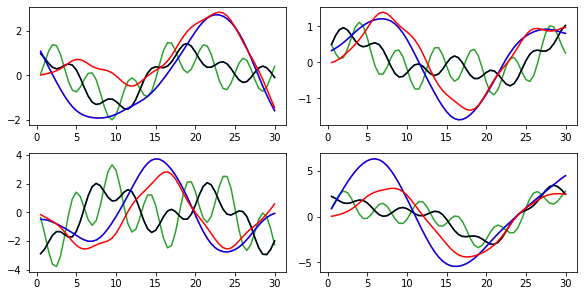

In [ ]:

test_input, test_correct_output, test_graphs, ts= make_inputs(nB =4)
test_output=network.predict_on_batch(test_input) # get some test predictions

plot4figs(test_input, test_correct_output, test_output, test_graphs, ts)


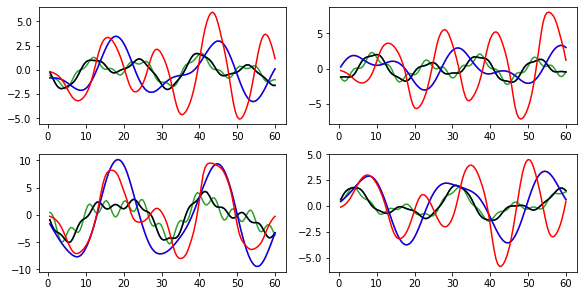

In [ ]:

factor = 2

test_input, test_correct_output, test_graphs, ts=      inputSeries(p_in=0,p_out=1, nsteps=factor*nsteps, T=factor*T, sizeOfBatch = 4)

test_output=Net.predict_on_batch(test_input) # get some test predictions

plot4figs(test_input, test_correct_output, test_output, test_graphs, ts)

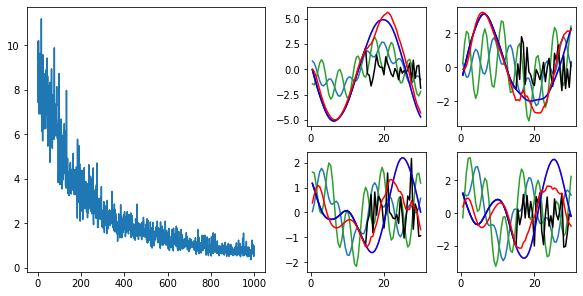

In [ ]:
make_inputs = lambda nB:inputTruncatedSeries(p_in=1,p_out=1,nsteps=nsteps, T=T,sizeOfBatch = nB)

network1=trainNetwork(Net=makeLSTM(20), makeInputs = make_inputs,
                     nParticles = multiple_coupled_oscillators_m.size)

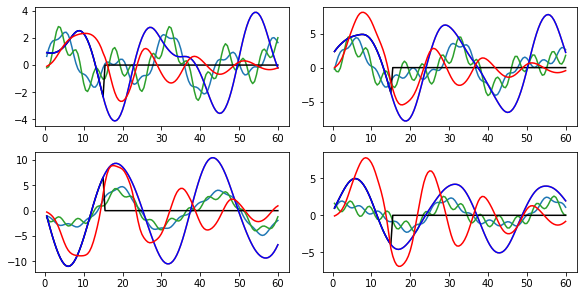

In [ ]:

factor = 2

test_input, test_correct_output, test_graphs, ts=      inputTruncatedSeries(p_in=1,p_out=1, nsteps=factor*nsteps, T=factor*T, sizeOfBatch = 4)

test_input[:,int(nsteps/2):,:]=0.0
test_output=Net.predict_on_batch(test_input) # get some test predictions

plot4figs(test_input, test_correct_output, test_output, test_graphs, ts)

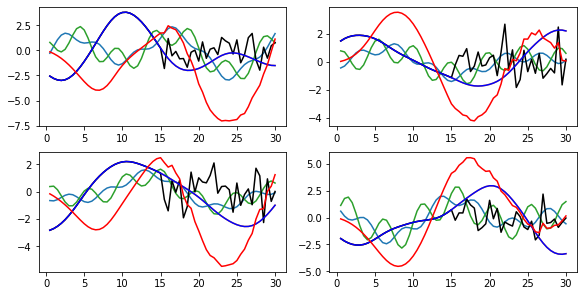

In [ ]:
test_input, test_correct_output, test_graphs, ts= make_inputs(nB =4)
test_output=network.predict_on_batch(test_input) # get some test predictions

plot4figs(test_input, test_correct_output, test_output, test_graphs, ts)